## The objective is of this notebook is to build a model to determine the type of flower for a given set of measurements of sepal length, sepal width, petal length, petal width.

### Load some useful libraries for plotting and data I/O and manipulation.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

C:\Users\Rich\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


### Read in the csv file with the flower measurement data.  This is unsupervised, in that all we have in the data is the 4 measurements for each flower.

In [2]:
df = pd.read_csv('flowers.csv',header=None)

In [3]:
df.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Its always good to look at the feature values.  Plot some histograms to look at the distribution and frequency of the values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000008542A20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000881C780>]], dtype=object)

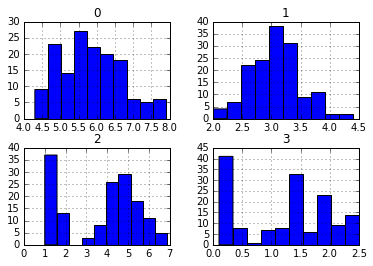

In [4]:
df.hist()

### No obvious spurious outliers.  But the plan for problem 2 is to build a clusterizing algorithm to group the flowers in the data based on the measurements.  This will be based on calculating the Euclidean distance between the points in the 4 dimensional space provided by the 4 measurements.  Thus it is wise to scale the data.  An existing function from sklearn is used for this purpose and done below.  The scaling scales the data so that it has a mean of zero and a standard deviation of one.

In [5]:
## normalize the features to have a mean of zero and a standard deviation of 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)

StandardScaler(copy=True, with_mean=True, with_std=True)

### Take a quick look at the scaled features below.

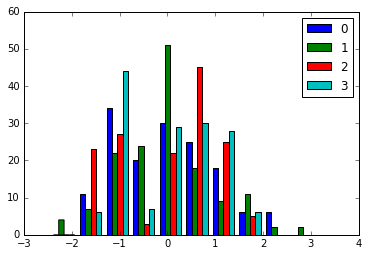

In [6]:
data = scaler.transform(df)
plt.hist(data,label=df.columns);
plt.legend(loc='upper right');

### Looks more or less reasonable.

## Problem 2 solution:
### The clustering algorithm is built below.  The standard k-means algorithm is implemented.  The model is implemented with a k of three because it is known that the data contains three different flowers.  The code is written for this specific case and will only handle k=3.  The algorithm could be generalized, but in the interest of time to get a quick result, the scope of the algorithm is limited.
### A series of helper functions is defined.  There is a function, init, to initialize the model and choose three random seeds.  There is a function, associatePoints, that calculates the (euclidean) distance of each data point to each of the seeds, and chooses to associate the data point with the seed that has the smallest distance away.  The function returns a dataframe containing the raw data, with an extra column added indicating the affiliation of that data point.  Lastly the function recenterSeeds recalculates the position of each seed based on the data associated with each seed.  This is done by calculating the centroid of the data in each group.

In [7]:
def init():
    startA = np.random.uniform(-3,3,size=(1,1,1,1))
    startB = np.random.uniform(-3,3,size=(1,1,1,1))
    startC = np.random.uniform(-3,3,size=(1,1,1,1))
    
    return startA, startB, startC
    
def associatePoints(data, startA, startB, startC):
    associationlist = []
    
    # calculate distance of each data point to the seeds
    for i in data:
        tempA = np.linalg.norm(startA-i)
        tempB = np.linalg.norm(startB-i)
        tempC = np.linalg.norm(startC-i)
        
        if tempA < tempB:
            associate = 'A'
            if tempC < tempA:
                associate = 'C'
        else:
            associate = 'B'
            if tempC < tempB:
                associate = 'C'
                
        associationlist.append(associate)
    
    df = pd.DataFrame(data)
    df['type'] = associationlist
    
    return df

def recenterSeeds(data):
    # calculate the centroid
    centroids = data.groupby('type').sum()/len(data)

    centroids = centroids.values.tolist()
    return centroids[0], centroids[1], centroids[2]

def plotProgress(df, seedA, seedB, seedC):
    ax = df[df['type']=='A'].plot(x=0,y=1, kind='scatter', color='Red')
    df[df['type']=='B'].plot(x=0,y=1, kind='scatter', color='Green', ax=ax)
    df[df['type']=='C'].plot(x=0,y=1, kind='scatter', color='Blue', ax=ax)
    plt.plot(seedA[[0,1]], kind='scatter',color='Black', ax=ax)
    plt.plot(seedB[[0,1]], kind='scatter',color='Black', ax=ax)
    plt.plot(seedC[[0,1]], kind='scatter',color='Black', ax=ax)

### Below is the implementation of the algorithm.  It returns a data frame with a column indicating the affiliation of the data point.

In [8]:
def clusterizer(data, n):
    
    # initialize the algorithm by selecting initial seeds
    seedA, seedB, seedC = init()
    # find the initial associations
    df = associatePoints(data, seedA, seedB, seedC)
    #plotProgress(df, seedA, seedB, seedC)
    
    # recalcualte the seeds from the centroids of the points in each group and reassociate
    # loop this a few times
    for i in xrange(n):
        seedA, seedB, seedC = recenterSeeds(df)
        df = associatePoints(data, seedA, seedB, seedC)
        #plotProgress(df, seedA, seedB, seedC)
    
    return df


### Now run the algorithm.  It is possible in an iteration for one group to get no flowers in it.  Thus the alogrithm is set up to make another attempt if this is the case.

In [9]:
for i in range(0,100):
    while True:
        try:
            temp = clusterizer(data, 6)
        except IndexError:
            continue
        break
        
df['type'] = temp['type']
df['type'].value_counts()

C    73
A    50
B    27
Name: type, dtype: int64

## Problem 2 a)
### Scatter plots of pairwise variables
#### 0 and 1 below

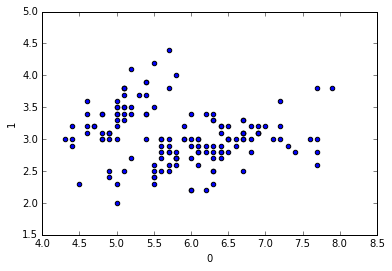

In [10]:
df.plot(x=0,y=1, kind='scatter');

#### features 1 and 2 below.

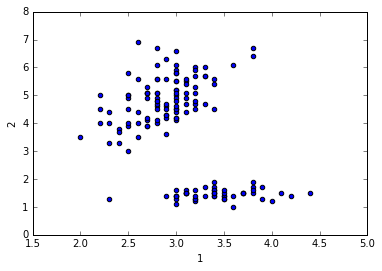

In [11]:
df.plot(x=1,y=2, kind='scatter')

#### Features 2 and 3 below.

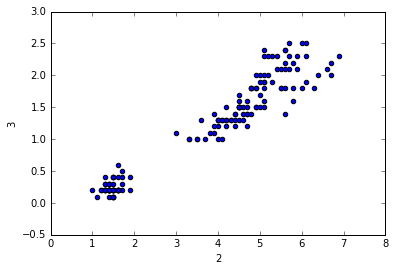

In [12]:
df.plot(x=2,y=3, kind='scatter')

## Problem 2 b)
### Recreate the same plots from a), but color code the points by group.
#### Features 2 and 3 below.

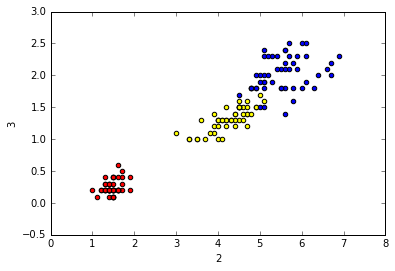

In [144]:
ax = df[df['type']=='A'].plot(x=2,y=3, kind='scatter', color='Red')
df[df['type']=='B'].plot(x=2,y=3, kind='scatter', color='Yellow', ax=ax)
df[df['type']=='C'].plot(x=2,y=3, kind='scatter', color='Blue', ax=ax)

#### Features 0 and 1 below.

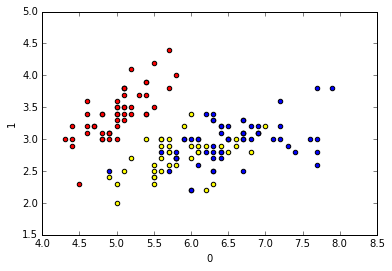

In [145]:
ax = df[df['type']=='A'].plot(x=0,y=1, kind='scatter', color='Red')
df[df['type']=='B'].plot(x=0,y=1, kind='scatter', color='Yellow', ax=ax)
df[df['type']=='C'].plot(x=0,y=1, kind='scatter', color='Blue', ax=ax)

#### Feautres 1 and 2 below.

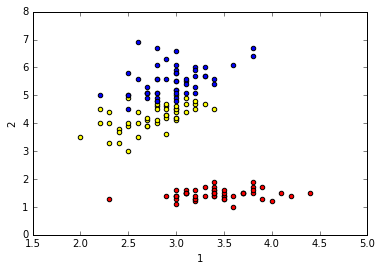

In [146]:
ax = df[df['type']=='A'].plot(x=1,y=2, kind='scatter', color='Red')
df[df['type']=='B'].plot(x=1,y=2, kind='scatter', color='Yellow', ax=ax)
df[df['type']=='C'].plot(x=1,y=2, kind='scatter', color='Blue', ax=ax)

## Problem 2 c)
### Evaluate the effectiveness of the clusterizer model.  It is known that the first 50 data points are associated with one flower type, the next 50 with another, and the last 50 with the final flower type.

### Get the value counts for each known group to evaluate the purity of the grouping.

In [16]:
shouldBeFlowerA = df['type'][:50]
shouldBeFlowerA.value_counts()

A    50
Name: type, dtype: int64

### The group of the first 50 points appear to be perfectly identified.
### Check the middle group below.

In [17]:
shouldBeFlowerB = df['type'][50:100]
shouldBeFlowerB.value_counts()

B    26
C    24
Name: type, dtype: int64

### The middle group is not as successful, it looks nearly half of these flowers are mis-labeled.
### Check the final group below.

In [18]:
shouldBeFlowerC = df['type'][100:150]
shouldBeFlowerC.value_counts()

C    49
B     1
Name: type, dtype: int64

### The final group also seems to be classified well.  It appears only one flower is mis-identified.

### To investigate this further, the profile of each group of flower is visualized below by producing histograms of the feautre values separated for each of the known flower groups.

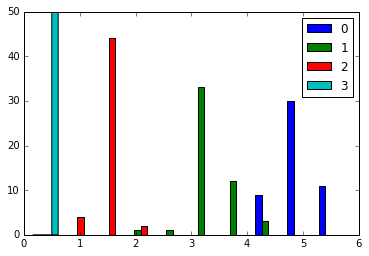

In [19]:
plt.hist(df[0:50].drop('type',axis=1),label=df.drop('type',axis=1).columns);
plt.legend(loc='upper right');

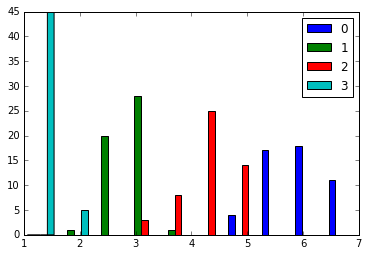

In [20]:
plt.hist(df[50:100].drop('type',axis=1),label=df.drop('type',axis=1).columns);
plt.legend(loc='upper right');

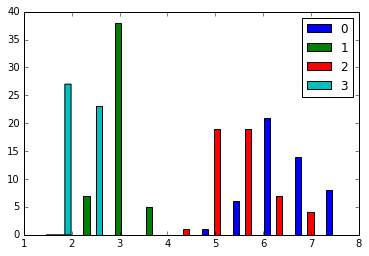

In [21]:
plt.hist(df[100:150].drop('type',axis=1),label=df.drop('type',axis=1).columns);
plt.legend(loc='upper right');

### By eye, it actually does look like the middle and last groups in the data have similar feature profiles.  There looks like there is strong overlap in the measured properties for these two type of flowers.  This can also be seen in the scatter plots shown for part 2 a).  It is not totally obvious by eye that there should be three groups.

In [22]:
df.drop('type',axis=1).corr()

,0,1,2,3
0,1.000000,-0.109369,0.871754,0.817954
1,-0.109369,1.000000,-0.420516,-0.356544
2,0.871754,-0.420516,1.000000,0.962757
3,0.817954,-0.356544,0.962757,1.000000


## Problem 3:
### Using the known labels, build a k-nearest neigbors model using 5-fold cross validation for testing and to determine the optimal value of k.  Built in functions from Python's sklearn libraries used for both the k-nearest neighbors algorithm, as well as for the mechanics of the 5-fold cross validation would make this an easy excerise.  This is done below, but first the kknn algorithm and the cross validation code is written by hand.  A grid search is also done to find the best value of k to use in knn.

### Create a new data frame with the correct label for each data point.

In [74]:
labeled_df = pd.DataFrame(data)
labeled_df['type'] = 'A'
labeled_df['type'][0:50] = 'A'
labeled_df['type'][50:100] = 'B'
labeled_df['type'][100:150] = 'C'
labeled_df['type'].value_counts()

C:\Users\Rich\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Rich\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rich\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


B    50
C    50
A    50
Name: type, dtype: int64

### Code up the knn algorithm

In [169]:
## my implementation of the knn algorithm

import math
import pandas as pd

# returns the distance between two points in arbitrary dimensions
## note that the vectors must be the same size or this will fail
def euclidean_distance(vec1, vec2):    
    temp = 0
    for i in xrange(4):
        temp += pow(float(vec1[i]) - float(vec2[i]), 2)

    return math.sqrt(temp)

# compute the distance between each data point in the sample and the test point
# return a data frame with the distance to the point as a new column
def get_distances(data, point):
    distances = []

    for i in xrange(len(data)):
        temp = data.drop('type',axis=1).iloc[i].tolist()
        distances.append( euclidean_distance(temp, point) )

    data['dist'] = distances

    return data

# find the k points with the closest distance
def findClosestPoints(data, k):
    temp = data.sort_values('dist')[0:k]

    return temp
    
# determine the label based on majority vote of near neighbors
def determineLabel(data):
    label = data['type'].value_counts(ascending=False).index[0]
    
    return label

## evaluate the accuracy of the model
def evaluate(data):
    #print data
    numberOfCorrect = len(data[data['type']==data['predicted_label']])

    return float(numberOfCorrect)/len(data)

## input expects a data frame with columns 0, 1, 2, 3, and type
def train_knn_and_evaluate(data_train, data_test, k):

    ## append the data frame with the distance 
    ##data_test['dist'] = data_test.drop('type', axis=1).apply(get_distances, args=(data_train))

    labels_test = []
    labels_train = []

    ## testing set evaluation
    for i in xrange(len(data_test)):
        point = data_test.drop('type',axis=1).iloc[i].tolist()
        temp = get_distances(data_train, point)
        temp = findClosestPoints(temp, k)
        label = determineLabel(temp)
        labels_test.append(label)
        
    ## training set evaluation
    for i in xrange(len(data_train)):
        point = data_train.drop('type',axis=1).iloc[i].tolist()
        temp = get_distances(data_train, point)
        temp = findClosestPoints(temp, k)
        label = determineLabel(temp)
        labels_train.append(label)
    
    data_test['predicted_label'] = labels_test
    data_train['predicted_label'] = labels_train

    return evaluate(data_test), evaluate(data_train)


### My implementation of the cross validation algorithm.  The idea is to split up the data into k equal parts.  Then train the model on the first k-1 parts, evaluating on the left out kth part.  The scores are averaged to get the final model score to get the smallest variance in the model.

In [170]:
## my implemenation for cross-validation

import numpy as np

#def train_model(data, model, n_neighbors):
    

def cross_validation(data, k, model_parm):
    ## split the data up into k pieces randomly
    ## start determining how many pieces of data go into each segment
    n = len(data)/k

    scores_test = []
    scores_train = []
    holder = {}

    ## choose a random set of row numbers for each fold
    for i in xrange(len(data)):
        temp = np.random.randint(0, k)
        point = data.iloc[i].tolist()
        try:
            holder[temp].append(point)
        except KeyError:
            holder[temp] = [point]
    
    ## at this point, should have a dictionary holding the data for each fold
    ## the last fold is the test fold not used in traing
    data_test = pd.DataFrame(holder[k-1], columns = [0,1,2,3,'type'])
    for i in xrange(0, k-1):
        data_train = pd.DataFrame(holder[i], columns = [0,1,2,3,'type'])
        temp = train_knn_and_evaluate(data_train, data_test, model_parm)
        scores_test.append(temp[0])
        scores_train.append(temp[1])
        
    
    return np.mean(scores_test), np.std(scores_test), np.mean(scores_train), np.std(scores_train)


### Now implement a grid search to find the best parameter

In [171]:
# the parameter values to test
params = [1, 3, 5, 10, 20, 50]

accuracytest_mean = []
accuracytest_std = []
accuracytrain_mean = []
accuracytrain_std = []

for i in params:
    temp = cross_validation(labeled_df, 5, i)  # 5 for 5-fold cv
    accuracytest_mean.append(temp[0])
    accuracytest_std.append(temp[1])
    accuracytrain_mean.append(temp[2])
    accuracytrain_std.append(temp[3])

## Problem 3 a)
### plot the prediction error (or accuracy in this case which is 1 - error)

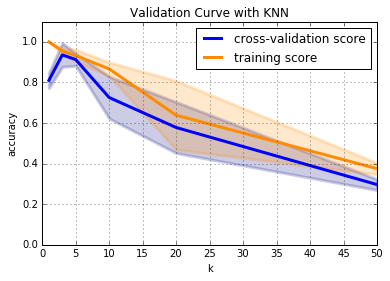

In [188]:
lw = 3

plt.plot(params, accuracytest_mean, label='cross-validation score', lw=lw)

plt.fill_between(params, np.array(accuracytest_mean) - np.array(accuracytest_std),
                 np.array(accuracytest_mean) + np.array(accuracytest_std), alpha=0.2,
                 color="navy", lw=lw)

plt.plot(params, accuracytrain_mean, label="training score", color='darkorange', lw=lw)

plt.fill_between(params, np.array(accuracytrain_mean) - np.array(accuracytrain_std),
                 np.array(accuracytrain_mean) + np.array(accuracytrain_std), alpha=0.2,
                 color="darkorange", lw=lw)


plt.ylim(0,1.1)
plt.xticks(np.arange(0, 51, 5))
plt.title("Validation Curve with KNN")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.grid(True)
plt.legend(loc="best");

### In the above plot, the training score shows the prediction accuracy on the training set.  The cross-validation score shows the prediction accuracy tested against the hold out testing set.

## Problem 3 b)
### The value of k best suited to make predictions is about 5.  This value is chosen because it is where the training and cross-validation accuracy values are both similar and large.  Additionally, this is where the standard deviation of the results from the different folds is the smallest (indicated by the blue band), indicating a fairly stable model.  The accuracy changes with k as k controls the complexity of the model.  The most complex model (meaning the most flexible boundaries) is achieved with k=1.  As can be seen in the above plot, this is where the training and cross validation accuracies diverge, with the training accuracy rising and the cross validation accuracy falling.  This is a sign of overfitting.  The model is fitting extremely well to the noise of the training data (perfect when k=1), but does not generalize as well to the unseen testing data, where the accuracy drops to 0.8.  As k increases to larger values, the model does not have enough flexibility and as a result has larger bias and cannot interpret the overall trend.  The effect is that the accuracy for both the training and cross validation sets decrease.

### Below is the knn and GridSearchCV performed with sklearn's built-in functions.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.learning_curve import validation_curve

### Create a new data frame with the correct label for each data point.

In [24]:
labeled_df = df
labeled_df['type'][0:50] = 'A'
labeled_df['type'][50:100] = 'B'
labeled_df['type'][100:150] = 'C'
labeled_df['type'].value_counts()

C:\Users\Rich\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Rich\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Rich\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


B    50
C    50
A    50
Name: type, dtype: int64

### The validation_curve function in sklearn is used to both scan over the k parameter space and to perform the cross validation.  It returns the results of the model for the training and testing data sets, reporting the mean and the standard deviation of the folds.

In [25]:
X, y = data, labeled_df['type']

param_range = [1, 3, 5, 10, 20, 50, 75]
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(), X, y, param_name="n_neighbors", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)

## Problem 3 a)
### Visualize the results below by showing the training error as a function of k.

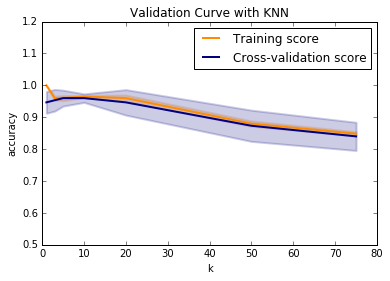

In [26]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNN")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.ylim(0.5, 1.2)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### In the above plot, the training score shows the prediction accuracy on the training set.  The cross-validation score shows the prediction accuracy tested against the hold out testing set.

## Problem 3 b)
### The value of k best suited to make predictions is about 12.  This value is chosen because it is where the training and cross-validation accuracy values are similar and are large.  Additionally, this is where the standard deviation of the results from the different folds is the smallest (indicated by the blue band), indicating a fairly stable model.  The accuracy changes with k as k controls the complexity of the model.  The most complex model (meaning the most flexible boundaries) is achieved with k=1.  As can be seen in the above plot, this is where the training and cross validation accuracies diverge, with the training accuracy rising and the cross validation accuracy falling.  This is a sign of overfitting.  The model is fitting extremely well to the noise of the training data, but does not generalize as well to the unseen testing data, though the overfitting does not seem that drastic.  As k increases to larger values, the model does not have enough flexibility and as a result has larger bias and cannot interpret the overall trend.  The effect is that the accuracy for both the training and cross validation sets decrease.